# Fundamentals of Software Systems (FSS)
**Software Evolution – Part 02 Assignment**

## Submission Guidelines

To correctly complete this assignment you must:

* Carry out the assignment in a team of 2 to 4 students.
* Carry out the assignment with your team only. You are allowed to discuss solutions with other teams, but each team should come up its own personal solution. A strict plagiarism policy is going to be applied to all the artifacts submitted for evaluation.
* As your submission, upload the filled Jupyter Notebook (including outputs) together with the d3 visualization web pages (i.e. upload everything you downloaded including the filled Jupyter Notebook plus your `output.json`)
* The files must be uploaded to OLAT as a single ZIP (`.zip`) file by 2023-12-04 18:00.


## Group Members
* Firstname, Lastname, Immatrikulation Number
* **TO BE FILLED**

## Task Context

In this assigment we will be analyzing the _elasticsearch_ project. All following tasks should be done with the subset of commits from tag `v1.6.0` to tag `v2.0.0`.

In [14]:
%pip install plotly
%pip install tdqm
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1334 sha256=4d9552c456f040f080553046f353739f3bdbc3891314976b629236654e07faed
  Stored in directory: c:\users\paull\appdata\local\pip\cache\wheels\af\02\71\aae0f7ee738abf19498353918ddae0f90a0d6ceb337b0bbc91
Successfully built tdqm
Note: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.2 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.2 kB ? eta -:--:--
     ------------------- ------------------ 30.7/61.2 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 61.2/61.2 kB 407.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/77.6 kB ? eta -:--:--
   ----------------

In [27]:
import os
from pydriller import Repository, Git
from tqdm import tqdm
from collections import defaultdict, Counter
import plotly.express as px
import subprocess
import platform
import json
import pandas as pd
from datetime import datetime
import numpy as np
import math
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [17]:
# Clone code from the repo and save it for code portability -> via normal git clone
url = "https://github.com/elastic/elasticsearch"
repo_path = os.path.join(os.getcwd(), 'elasticsearch')
clone = f"git clone {url} \"{repo_path}\""

os.system(clone) # Cloning

128

In [18]:
from_tag = "v1.6.0"
to_tag = "v2.0.0"

In [19]:
# define Repository
gr = Git(repo_path)
from_tag = "v1.6.0"
to_tag = "v2.0.0"
since_time = gr.get_commit_from_tag(from_tag).committer_date
to_time = gr.get_commit_from_tag(to_tag).committer_date

repo = Repository(repo_path, since=since_time, to=to_time)
print(f"Analyzing repo from {from_tag} to {to_tag}, which are commits from {since_time} to {to_time}")

Analyzing repo from v1.6.0 to v2.0.0, which are commits from 2015-06-09 13:35:08+00:00 to 2015-10-21 23:01:03+02:00


## Task 1: Author analysis

In the following, please consider only `java` files.

The first task is to get an overview of the author ownership of the _elasticsearch_ project. In particular, we want to understand who are the main authors in the system between the two considered tags, the authors distribution among files and the files distribution among authors. To this aim, perform the following:

* create a dictionary (or a list of tuples) with the pairs author => number of modified files
* create a dictionary (or a list of tuples) with the pairs file => number of authors who modified the file
* visualize the distribution of authors among files: the visualization should have on the x axis the number of authors per file (from 1 to max), and on the y axis the number of files with the given number of authors (so for example the first bar represent the number of files with single author)
* visualize the distribution of files among authors: the visualization should have on the x axis the number of files per author (from 1 to max), and on the y axis the number of authors that own the given number of files (so for example the first bar represent the minor contributors, i.e., the number of authors who own 1 file)

Comment the two distribution visualizations.



Now, let's look at the following 3 packages in more details:

1. `src/main/java/org/elasticsearch/common`
2. `src/main/java/org/elasticsearch/rest`
3. `src/main/java/org/elasticsearch/cluster`

Create a function that, given the path of a package and a modification type (see class Modification below), returns a dictionary of authors => number, where the number counts the total lines added or removed or added+removed or added-removed (depending on the given Modification parameter), for the given package. To compute the value at the package level, you should aggregate the data per file.

Using the function defined above, visualize the author contributions (lines added + lines removed). The visualization should have the author on the x axis, and the total lines on the y axis. Sort the visualization in decreasing amount of contributions, i.e., the main author should be the first.

Compare the visualization for the 3 packages and comment.

In [20]:
def create_dictionary(repo):
    authors_dict = defaultdict(set)
    files_dict = defaultdict(set)

    commits = [commit for commit in repo.traverse_commits()]

    for commit in tqdm(commits, desc="Analyzing commits", unit="commit"):
        for file in commit.modified_files:
            filename = file.filename
            if not filename.endswith(".java"):
                continue

            authors_dict[commit.author.name].add(filename)  # since dict is a set, we don't have to care about duplicities
            files_dict[filename].add(commit.author.name)  # since dict is a set, we don't have to care about duplicities

    # perform counting on both dictionaries to get the numbers
    authors_dict = {author: len(files) for author, files in authors_dict.items()}
    files_dict = {file: len(authors) for file, authors in files_dict.items()}
    return authors_dict, files_dict

In [21]:
authors_dict, files_dict = create_dictionary(repo)

Analyzing commits: 100%|██████████| 4017/4017 [07:19<00:00,  9.14commit/s] 


In [28]:
def plot_interactive_bar_chart(dictionary, title, ylabel, xlabel, top_n=10):
    # Counting the occurrences in the dictionary
    counts = Counter(dictionary.values())

    # Sorting the counts dictionary by values in descending order
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[0]))

    # Getting the top n most common elements after sorting

    # Preparing data for plotting
    values = list(sorted_counts.keys())
    frequencies = list(sorted_counts.values())

    # Creating an interactive bar chart
    fig = px.bar(x=values, y=frequencies, labels={'x': xlabel, 'y': ylabel}, title=title)
    fig.update_layout(xaxis={'type':'category'})
    fig.show()

In [29]:
plot_interactive_bar_chart(files_dict, "How many files are used by how many authors (so for example the first bar represent the number of files with single author)", "Number of authors", "Number of files")
plot_interactive_bar_chart(authors_dict, "How many authors have interacted with how many files (so for example the first bar represent the minor contributors, i.e., the number of authors who own 1 file)", "Number of authors", "Number of files")

In [10]:
from enum import Enum 

class Modification(Enum):
    ADDED = "Lines added"
    REMOVED = "Lines removed"
    TOTAL = "Lines added + lines removed"
    DIFF = "Lines added - lines removed"

In [11]:
def calc_authors_nr_package_modifications(packages, from_commit_date, to_commit_date):
    authors_nr_package_modifications = {}
    for commit in Repository(repo_path, since=from_commit_date, to=to_commit_date).traverse_commits():
        for file in commit.modified_files:
            filename = file.filename
            if not filename.endswith(".java"):
                continue
            path = file.new_path if file.new_path is not None else file.old_path
            for package in packages:
                if package not in file.new_path:
                    continue
                p = package.rsplit("\\")[-1]
                if p not in authors_nr_package_modifications:
                    authors_nr_package_modifications[p] = {}
                author = commit.author.name
                if file.added_lines != 0:
                    if Modification.ADDED.name not in authors_nr_package_modifications[p]:
                        authors_nr_package_modifications[p][Modification.ADDED.name] = {}
                    if author not in authors_nr_package_modifications[p][Modification.ADDED.name]:
                        authors_nr_package_modifications[p][Modification.ADDED.name][author] = 0
                    authors_nr_package_modifications[p][Modification.ADDED.name][author] += file.added_lines
                if file.deleted_lines != 0:
                    if Modification.REMOVED.name not in authors_nr_package_modifications[p]:
                        authors_nr_package_modifications[p][Modification.REMOVED.name] = {}
                    if author not in authors_nr_package_modifications[p][Modification.REMOVED.name]:
                        authors_nr_package_modifications[p][Modification.REMOVED.name][author] = 0
                    authors_nr_package_modifications[p][Modification.REMOVED.name][author] += file.deleted_lines
                if file.added_lines != 0 or file.deleted_lines != 0:
                    if Modification.TOTAL.name not in authors_nr_package_modifications[p]:
                        authors_nr_package_modifications[p][Modification.TOTAL.name] = {}
                    if author not in authors_nr_package_modifications[p][Modification.TOTAL.name]:
                        authors_nr_package_modifications[p][Modification.TOTAL.name][author] = 0
                    authors_nr_package_modifications[p][Modification.TOTAL.name][author] += file.added_lines + file.deleted_lines
                    if Modification.DIFF.name not in authors_nr_package_modifications[p]:
                        authors_nr_package_modifications[p][Modification.DIFF.name] = {}
                    if author not in authors_nr_package_modifications[p][Modification.DIFF.name]:
                        authors_nr_package_modifications[p][Modification.DIFF.name][author] = 0
                    authors_nr_package_modifications[p][Modification.DIFF.name][author] += file.added_lines - file.deleted_lines
    return authors_nr_package_modifications


In [12]:
packages = [
    "src\\main\\java\\org\\elasticsearch\\common",
    "src\\main\\java\\org\\elasticsearch\\rest",
    "src\\main\\java\\org\\elasticsearch\\cluster",
]

authors_nr_package_modifications = calc_authors_nr_package_modifications(packages, from_commit_date, to_commit_date)


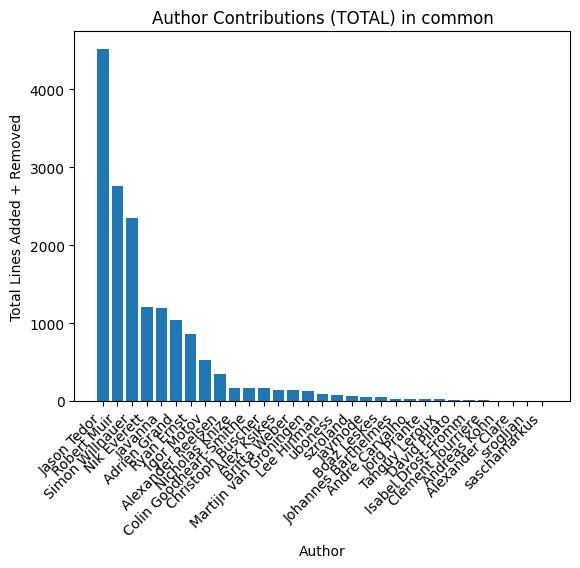

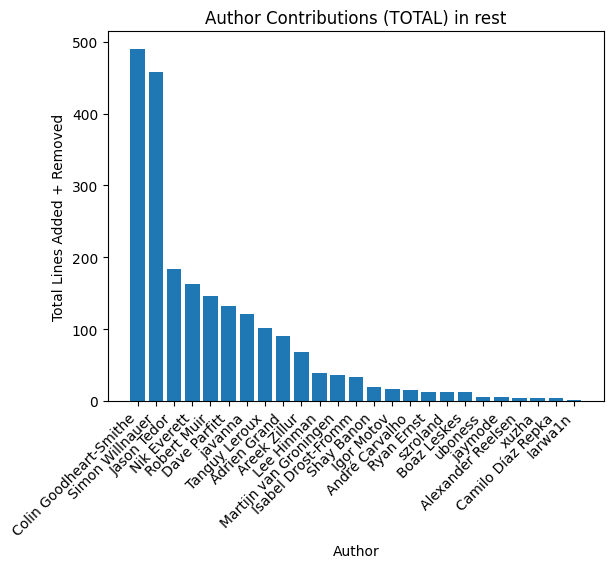

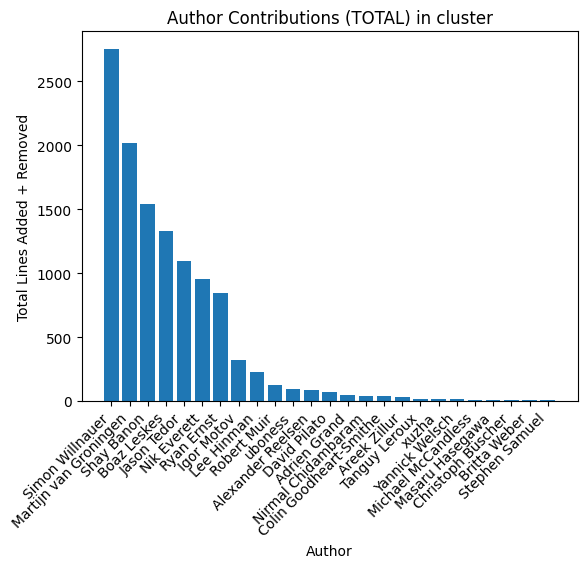

In [13]:
def visualize_author_contributions(author_contributions, package, modification=Modification.TOTAL.name):
    # Extract 'TOTAL' contributions only
    total_contributions = author_contributions[package][modification]

    # Sort contributions by decreasing amount
    sorted_contributions = sorted(total_contributions.items(), key=lambda x: x[1], reverse=True)
    authors, contributions = zip(*sorted_contributions)

    plt.bar(authors, contributions)
    plt.xlabel('Author')
    plt.ylabel('Total Lines Added + Removed')
    plt.title(f'Author Contributions ({modification}) in {package}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

for package in packages:
    p = package.rsplit("\\")[-1]
    visualize_author_contributions(authors_nr_package_modifications, p, Modification.TOTAL.name)

## Task 2: Knowledge loss

We now want to analyze the knowledge loss when the main contributor of the analyzed project would leave. For this we will use the circle packaging layout introduced in the "Code as a Crime Scene" book. This assignment includes the necessary `knowledge_loss.html` file as well as the `d3` folder for all dependencies. Your task is to create the `output.json` file according to the specification below. This file can then be visualized with the files provided.

For showing the visualization, once you have the output as `output.json` you should

* make sure to have the `knowledge_loss.html` file in the same folder
* start a local HTTP server in the same folder (e.g. with python `python3 -m http.server`) to serve the html file (necessary for d3 to work)
* open the served `knowledge_loss.html` and look at the visualization

Based on the visualization, comment on how is the project in terms of project loss and what could happen if the main contributor would leave.


### Output Format for Visualization

* `root` is always the root of the tree
* `size` should be the total number of lines of contribution
* `weight` can be set to the same as `size`
* `ownership` should be set to the percentage of contributions from the main author (e.g. 0.98 for 98% if contributions coming from the main author)

```
{
  "name": "root",
  "children": [
    {
      "name": "test",
      "children": [
        {
          "name": "benchmarking",
          "children": [
            {
              "author_color": "red",
              "size": "4005",
              "name": "t6726-patmat-analysis.scala",
              "weight": 1.0,
              "ownership": 0.9,
              "children": []
            },
            {
              "author_color": "red",
              "size": "55",
              "name": "TreeSetIterator.scala",
              "weight": 0.88,
              "ownership": 0.9,
              "children": []
            }
          ]
        }
      ]
    }
  ]
}
```

### JSON Export

For exporting the data to JSON you can use the following snippet:

```
import json

with open("output.json", "w") as file:
    json.dump(tree, file, indent=4)
```

## Task 3: Code Churn Analysis

The third and last task is to analyze the code churn of the _elasticsearch_ project. For this analysis we look at the code churn, meaning the daily change in the total number of lines of the project.

Visualize the code churn over time bucketing the data by day. Remember that you'll need to consider also the days when there are no commits.

Look at the churn trend over time, identify one outlier, and for it:

* investigate if it was caused by a single or multiple commits (since you are bucketing the data by day)
* find the hash of the involved commit(s)
* find the involved files, and for each file look at the number of lines added and/or deleted as well as the modification type (addition, deletion, modification, renaming)
* look at the commit messages

Based on the above, discuss the potential reasons for the outlier and if it should be a reason for concern.